# Text Classification and Analysis using Naive Bayes, Logistic Regression, and Neural Networks 

##### By: Shreya Valaboju
##### Section: CS 4395.001
##### * Before executing this notebook, ensure all necessary libraries/modules are installed. Simply run the notebook from top to bottom. 

The dataset is used to solve a multi-class classification problem, classifying emails as fraud, commerical spam, phishing, or none (false-positive). This dataset is dervied from Kaggle, and is called "Phishing Email Data by Type." In this notebook, we will try to train our model using various algorithms, such as Naive Bayes, Logistic Regression, and a Neural Network to be able to predict whether a given email message is fraud, commerical spam, phishing, or none (false-positive). The dataset has 3 columns: 'Subject', 'Text', and 'Type.'The 'Text' column holds the entire email message. The subject of the emails is also another attribute in the dataset, however, in this notebook we will only be using the "Text" and "Type" columns. We will vectorize the "Text" column to derive the features for the model and the "Type" will represent our target class. Here is the link to the dataset: 
https://www.kaggle.com/datasets/charlottehall/phishing-email-data-by-type


#### 1. Import Libraries and Preprocessing

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# get a text classification dataset (hosted on a public url via github)
data_url = "https://raw.githubusercontent.com/shreyavala/nlp_text_classification_data/main/phishing_data_by_type.csv"
df=pd.read_csv(data_url)
df

,Subject,Text,Type
0,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP.\n\...,Fraud
1,URGENT ASSISTANCE /RELATIONSHIP (P),"Dear Friend,\n\nI am Mr. Ben Suleman a custom ...",Fraud
2,GOOD DAY TO YOU,FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...,Fraud
3,from Mrs.Johnson,Goodday Dear\n\n\nI know this mail will come t...,Fraud
4,Co-Operation,FROM MR. GODWIN AKWESI\nTEL: +233 208216645\nF...,Fraud
...,...,...,...
154,These Bags Just Arrived For Spring,Bags so perfect—you'll never want to be withou...,Commercial Spam
155,POTUS Comes to Broadway this April! Get Ticket...,INAUGURAL BROADWAY PERFORMANCE APRIL 14\r\nA N...,Commercial Spam
156,Let’s talk about Bridgerton!,GET THE BEST OF EVERYTHING IN THE APP\n\nSTARB...,Commercial Spam
157,MONDAY MIX: All eyes on Ukraine,Hi!\n \nSpring forward with our newest noPac c...,Commercial Spam


In [3]:
print("Shape(Rows, Columns): ",df.shape)

Shape(Rows, Columns):  (159, 3)


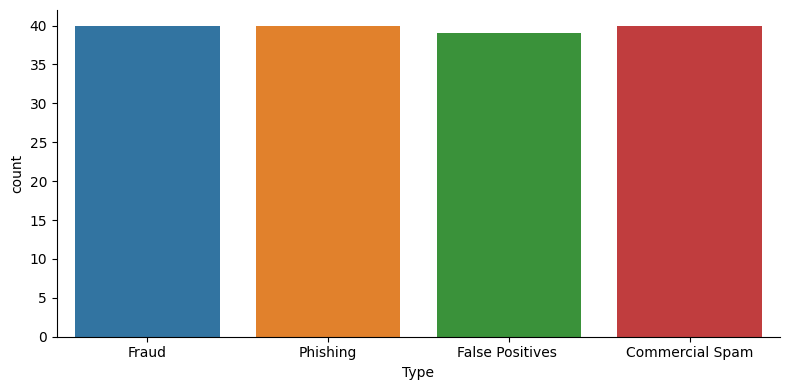

In [4]:
# creates a graph showing the distribution of the target classes

sns.catplot(data=df, kind='count', x='Type', height=4, aspect=2)

From this distribution we can see that the classes are fairly balanced. There is a proportional number of instances between Fraud, Phishing, False Positives, and Commerical Spam emails. We do not need to undersample or oversample any class in this dataset. This dataset it relatively small, with 159 instances and 3 attributes. 


In [5]:
# preprocess the 'Text' column (lowercase, remove punctuation and numbers)
df['Text'] = df['Text'].str.lower() # lower
df['Text'] = df['Text'].str.replace('[^\w\s]','') # remove punctuation
df['Text'] = df['Text'].str.replace('\n','') # remove newlines
df['Text'] = df['Text'].str.replace('\t','') # remove tabs
df['Text'] = df['Text'].str.replace('\d+', '') # remove numbers
df

<ipython-input-5-a91182193439>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace('[^\w\s]','') # remove punctuation
<ipython-input-5-a91182193439>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Text'] = df['Text'].str.replace('\d+', '') # remove numbers


,Subject,Text,Type
0,URGENT BUSINESS ASSISTANCE AND PARTNERSHIP,urgent business assistance and partnershipdear...,Fraud
1,URGENT ASSISTANCE /RELATIONSHIP (P),dear friendi am mr ben suleman a custom office...,Fraud
2,GOOD DAY TO YOU,from his royal majesty hrm crown ruler of elem...,Fraud
3,from Mrs.Johnson,goodday deari know this mail will come to you ...,Fraud
4,Co-Operation,from mr godwin akwesitel fax before i introd...,Fraud
...,...,...,...
154,These Bags Just Arrived For Spring,bags so perfectyoull never want to be without ...,Commercial Spam
155,POTUS Comes to Broadway this April! Get Ticket...,inaugural broadway performance april \ra new c...,Commercial Spam
156,Let’s talk about Bridgerton!,get the best of everything in the appstarbucks...,Commercial Spam
157,MONDAY MIX: All eyes on Ukraine,hi spring forward with our newest nopac course...,Commercial Spam


In [6]:
# use tf-idf vectorization to extract features (tf-idf frequencies) and preprocess by lemmatization
class LemmaTokenizer:
     def __init__(self):
         self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vectorizer = TfidfVectorizer(stop_words = 'english',tokenizer=LemmaTokenizer(),min_df=3) # intitialize a tf-idf vectorizer (with stopwords removal and lemmatization)

vectorized_data = vectorizer.fit_transform(df['Text'].values.astype('U')) # tell the vectorizer to read our data

# construct a dataframe with vectorized words (dataframe will be large)
df_vectorized= pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out())
df_vectorized.head()

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


,abacha,abandoned,abidjan,able,abroad,academic,accept,accepted,access,accordance,...,youas,youi,youll,young,youre,youth,youtube,youve,zip,𝘧𝘳𝘰𝘮
0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.14028,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.070671,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.0,0.0,0.0,0.200996,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.000000,0.0,0.068949,0.0,0.0,0.0,...,0.083368,0.065382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2. Train/Test Split and Distribution of Data

In [7]:
# train/test split
X = df_vectorized  # drop any other columns/features deemed unecessary for the X
y = df["Type"] # target class


x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = 0.25) # split data into 75% train, 25% test

print("X shape: ", x_train.shape, x_test.shape)
print("y shape: ", y_train.shape, y_test.shape)

X shape:  (119, 1251) (40, 1251)
y shape:  (119,) (40,)


#### 3. Run and Evaluate Naive Bayes, Logistic Regression, Neural Network

##### Naive Bayes

In [8]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB()
naive_bayes.fit(x_train, y_train)

MultinomialNB()

In [9]:
# test the naive bayes model by predicting 
y_pred = naive_bayes.predict(x_test)

In [10]:
#score the model printing accuracy, precision, and recall curves
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

 Commercial Spam       0.75      0.90      0.82        10
False Positives        0.86      0.75      0.80         8
           Fraud       1.00      1.00      1.00        13
        Phishing       0.88      0.78      0.82         9

        accuracy                           0.88        40
       macro avg       0.87      0.86      0.86        40
    weighted avg       0.88      0.88      0.87        40



##### Logistic Regression

In [11]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
logreg_model.fit(x_train,y_train)

LogisticRegression(multi_class='multinomial')

In [12]:
# test the logistic regression model by predicting 
y_pred = logreg_model.predict(x_test)

In [13]:
#score the model and print accuracy, precision, and recall curves
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

 Commercial Spam       0.80      0.80      0.80        10
False Positives        0.86      0.75      0.80         8
           Fraud       1.00      1.00      1.00        13
        Phishing       0.80      0.89      0.84         9

        accuracy                           0.88        40
       macro avg       0.86      0.86      0.86        40
    weighted avg       0.88      0.88      0.87        40



##### Neural Network

In [14]:
# Neural Networks
from sklearn.neural_network import MLPClassifier

neural_net = MLPClassifier(activation = 'relu',random_state=1, learning_rate='constant', learning_rate_init=0.001)
neural_net.fit(x_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=1)

In [15]:
# test the neural network by predicting 
y_pred = neural_net.predict(x_test)

In [16]:
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

 Commercial Spam       0.77      1.00      0.87        10
False Positives        0.78      0.88      0.82         8
           Fraud       1.00      0.92      0.96        13
        Phishing       1.00      0.67      0.80         9

        accuracy                           0.88        40
       macro avg       0.89      0.87      0.86        40
    weighted avg       0.90      0.88      0.87        40



### 4. Analysis

From running the three algorithms, we can see that the accuracy is fairly high and consistent across all with 88%. 

When running naive bayes, it performed best at detecting fraud. Interestingly, it perfomed the same for detecting commerical spam as logistic regression. Additionally, it has a relatively low precision and high recall for commerical spam, but a higher recall than precision for phishing, which is oppsite to what logitic regression had in terms of results. 


For logistic regression, accuracy was once again sitting at 88%. For correctly detecting commerical spam, false positives, and fraud, the algorithm had a relatively high precision and high recall. It perfomed the worst at detecting false positives with precision at 0.86 and recall at 0.75. These differences are not concerning, but could be due to the fact that the number of actual false positive instances were lower than the other 3 types at 8. In general a very low precision rate means that the model predicts a lot of phishing emails even if they aren't. A low recall and high precision means that the model fails to detect many instances of a type emails, but when it does, it's fairly believable. This doesn't apply to our model because logistic regression performed well across all classes.

Lastly, using a neural network, in our case sklearn's MLPClassifier, accuracy was tied with the highest at 88%. Similarly, it perfomed very well detecting fraud. All across, the model perfomed well in detecting commerical spam, false positives, and phishing all with high recalls and precision. However, it had a high precision and lower recall for phishing, and a low precision and high recall for false positives. These results can be explained by the lower numbers of actual instances of those classes and by the explanation given above. 

Overall, all 3 models performed very well, especially at detecting fraud emails. However, precision, recall, f1, and accuracy for all classes for all 3 models were relatively high but slight differences between classes.




